# Implementation of ResNet in PyTorch

## This notebook is a work in progress


Outline for Implementation/Analysis
- problem it's trying to address
- main idea behind residual learning in general + shortcut
- previous work (earlier, later, at all?)
- mention we'll look at the ImageNet implementation (mainly to gain the idea of the architecture), then implement CIFAR-10
- implementation as per the paper:
    - dataset - imagenet
    - architectures:
        - plain
        - residual - two types of shortcuts:
            - A) identity mapping with zero padding for more channels, stride=2 for different feature map size
            - B) 1x1 convolution to change the dimensionality, also stride=2 for different feature map size 
        -> implementation of the basic block
        - at some point, gotta understand the A/B/C projection type
        - bottleneck mention, but not used (could show how to implement it though)
- look at the architectures used on ImageNet
- deep dive into CIFAR-10


This notebook contains an auhtentic implementation of the ResNet architecture, described in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Due to the limitations such as access to ImageNet and lack of computational resources, I won't aim for the exact same architecture (like I did in e.g. with the LeNet model) - instead, I'll provide a detailed analysis of the paper and description of the building blocks of the architecture & training objective, followed by a slightly customized implementation reflecting these building blocks on CIFAR-10.

Here's an outline of the notebook:

- Part I: Paper Analysis

- Part 2: Implementation

## Part I: Paper Analysis

### Context and Motivation
The core question the paper is trying to answer is whether achieving better models is as simple as stacking more layers. Two main sub-problems arise:
- Vanishing/exploding gradients - laregly addressed by normalization
- Deeper models achieve **worse** accuracy than their shallower counterparts

The second problem is particularly interesting - if we train a shallow network, adding more layers should't, in theory, worsen the performance, because the network can simply learn the identity mapping in these deeper layer, i.e. the output of the shallower is simply copied through the additional layers without any transformation (called "a solution by construction" by the authors). Thus, the deeper model should have at least the same accuracy as the shallower one, which isn't the case in practice. The main reason for this (and the key motivation for the paper) is likely the difficulyt of learning an identity/linear mapping by a stack of non-linear layers. In other words, with our current solvers & training methods, approximating the identity mapping isn't usually feasible. To address this, the authors propose the "Residual Learning Framework," which change the objective under which we train the models.

### The Residual Learning Objective
Normally, we define the learning objective as approximating some underlying function $f(x)$ - the core assumption is that a stack of non-linear layers can learn arbitrarily complicated function. Therefore, it should also be able to learn an approximation of a "residual function" $f(x) - x$  

In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.io import decode_image
from torchinfo import summary

writer = SummaryWriter()

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print(f"using {device} device")

# torch.manual_seed(42)


using cuda device


In [2]:
dataset_path = '~/Dev/datasets/cifar-10'

transform_train = transforms.Compose([
    transforms.Pad(4),                # Pad 4 pixels on each side (32->40)
    transforms.RandomCrop(32),        # Randomly crop back to 32x32
    transforms.RandomHorizontalFlip(),# Random horizontal flip
    transforms.ToTensor(),            # Convert PIL image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2470, 0.2435, 0.2616)) # Normalize with CIFAR-10 stats
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2470, 0.2435, 0.2616))
])


train_data = datasets.CIFAR10(
    root=dataset_path,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.CIFAR10(
    root=dataset_path,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 128

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32])
Shape of y: torch.Size([128]) torch.int64


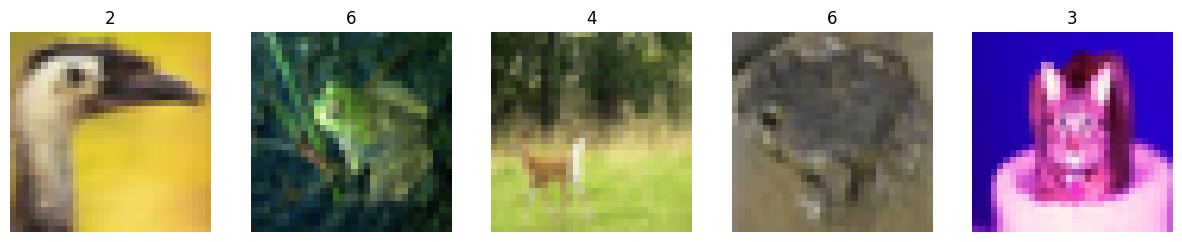

In [16]:
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Randomly select indices
indices = random.sample(range(len(train_data)), num_images)

for i, idx in enumerate(indices):
    img, label = train_data[idx]
    img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].set_title(f"{label}")
    axes[i].axis('off')

plt.show()

In [17]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        if not downsample:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x

        if self.downsample:
            identity = F.avg_pool2d(identity, kernel_size=1, stride=2)
            channels_to_pad = self.bn1.num_features - x.size(1)
            if channels_to_pad > 0:
                pad = torch.zeros(x.size(0), channels_to_pad, x.size(2), x.size(3),
                                  device=x.device, dtype=x.dtype)
                x = torch.cat([x, pad], dim=1)
        else:
            identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out
    
class ResNet20(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = nn.Sequential(
            ResidualBlock(16, 16, downsample=False),
            ResidualBlock(16, 16, downsample=False),
            ResidualBlock(16, 16, downsample=False)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(16, 32, downsample=True),
            ResidualBlock(32, 32, downsample=False),
            ResidualBlock(32, 32, downsample=False)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),
            ResidualBlock(64, 64, downsample=False),
            ResidualBlock(64, 64, downsample=False)
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


class ResNet20Old(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet20, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        # 32x32 feature map (6 layers total)
        self.conv2_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True)
            ) for _ in range(6)]
        )

        # 16x16 feature map (downsample + 5 layers = 6 layers total)
        self.conv3_downsample = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        self.bn3_downsample = nn.BatchNorm2d(32)
        self.conv3_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True)
            ) for _ in range(5)]
        )

        # 8x8 feature map (downsample + 5 layers = 6 layers total)
        self.conv4_downsample = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn4_downsample = nn.BatchNorm2d(64)
        self.conv4_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            ) for _ in range(5)]
        )

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.conv2_layers(x)

        x = self.relu(self.bn3_downsample(self.conv3_downsample(x)))
        x = self.conv3_layers(x)

        x = self.relu(self.bn4_downsample(self.conv4_downsample(x)))
        x = self.conv4_layers(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [19]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    corrects = 0
    total_samples = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0) # multiply by batch size
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == y)
        total_samples += X.size(0)

        if batch % 100 == 99:
            current = batch * batch_size + len(X)
            current_loss = loss.item()  # current batch loss
            current_acc = corrects.double() / total_samples  # or size if you want the fraction relative to full dataset
            print(f"[Train] loss: {current_loss:>7f} | accuracy: {(100 * current_acc):>0.1f}% [{current:>5d}/{size:>5d}]")

    epoch_loss = running_loss / total_samples
    epoch_acc = corrects.double() / total_samples

    return epoch_loss, epoch_acc
    
def validate(dataloader, model, loss_fn):
    model.eval()  
    size = len(dataloader.dataset)
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == y)
            total_samples += X.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = corrects.double() / total_samples
    return epoch_loss, epoch_acc


In [20]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

In [21]:
model = ResNet20(num_classes=10).to(device)
model.apply(weights_init)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.1
weight_decay = 0.0001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
epochs = 15

In [11]:
experiment_name = "ResNet20"
writer = SummaryWriter(log_dir=f"runs/{experiment_name}")

In [22]:
metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for e in range(epochs):
    print(f"\nEpoch {e + 1}/{epochs} | Learning Rate: {optimizer.param_groups[0]['lr']:.5f}:")
    
    # train phase
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    metrics['train_loss'].append(train_loss)
    metrics['train_accuracy'].append(train_acc)

    val_loss, val_acc = validate(val_dataloader, model, loss_fn)
    metrics['val_loss'].append(val_loss)
    metrics['val_accuracy'].append(val_acc)

    print("-----") 
    print(f"Train loss: {train_loss:>7f} | Train accuracy: {100 * train_acc:>0.1f}%")
    print(f"Val loss: {val_loss:>7f} | Val accuracy: {100 * val_acc:>0.1f}%")

    # writer.add_scalar("loss/train", train_loss, e)
    # writer.add_scalar("acc/train", train_acc, e)
    # writer.add_scalar("loss/val", val_loss, e)
    # writer.add_scalar("acc/val", val_acc, e)

# writer.flush()
# writer.close()


Epoch 1/15 | Learning Rate: 0.10000:
[Train] loss: 1.780395 | accuracy: 27.6% [12800/40000]
[Train] loss: 1.355571 | accuracy: 33.6% [25600/40000]
[Train] loss: 1.435699 | accuracy: 37.4% [38400/40000]
-----
Train loss: 1.786104 | Train accuracy: 37.9%
Val loss: 1.591712 | Val accuracy: 44.7%

Epoch 2/15 | Learning Rate: 0.10000:
[Train] loss: 1.286020 | accuracy: 50.0% [12800/40000]
[Train] loss: 1.297718 | accuracy: 51.4% [25600/40000]
[Train] loss: 1.249112 | accuracy: 53.2% [38400/40000]
-----
Train loss: 1.280719 | Train accuracy: 53.5%
Val loss: 1.332493 | Val accuracy: 53.8%

Epoch 3/15 | Learning Rate: 0.10000:
[Train] loss: 1.113035 | accuracy: 61.2% [12800/40000]
[Train] loss: 0.950455 | accuracy: 62.0% [25600/40000]
[Train] loss: 0.882819 | accuracy: 63.0% [38400/40000]
-----
Train loss: 1.032384 | Train accuracy: 63.2%
Val loss: 1.038336 | Val accuracy: 63.3%

Epoch 4/15 | Learning Rate: 0.10000:
[Train] loss: 0.825169 | accuracy: 68.0% [12800/40000]
[Train] loss: 0.891744

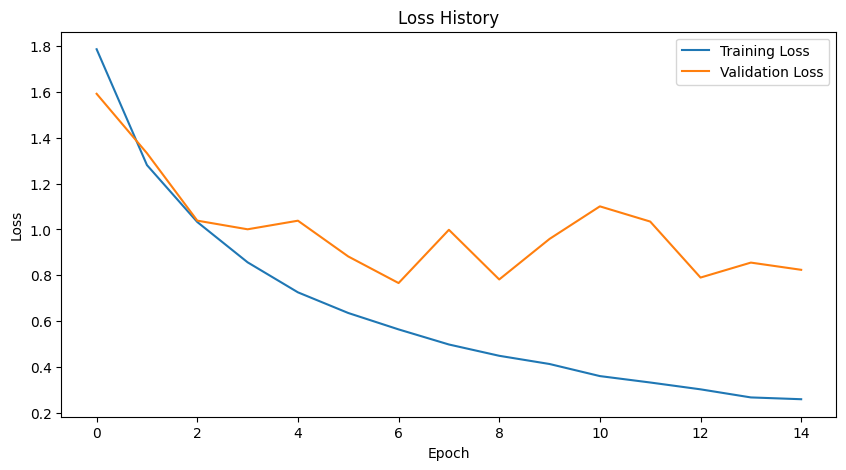

In [23]:
plt.figure(figsize=(10,5))
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()